In [1]:
!git clone https://github.com/mlyulko145/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project.git

Cloning into 'AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 110 (delta 39), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 55.58 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
%cd AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project

/var/www/filebrowser/.projects/d30108ff-ec67-4733-bfac-af4c728939ff/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project


In [3]:
!ls

README.md  data  notebook  src	tests


In [4]:
%cd notebook

/var/www/filebrowser/.projects/d30108ff-ec67-4733-bfac-af4c728939ff/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project/notebook


In [5]:
!pip install pandas matplotlib pytest

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [6]:
import pandas as pd

prices_df = pd.read_csv("../data/prices.csv")
nec_df = pd.read_csv("../data/necessity_survey.csv")

print(prices_df.head())
print(nec_df.head())


   food      store  price  expiration_days
0  Milk   ShopRite   3.49                7
1  Milk  Walgreens   3.99                7
2  Milk     Target   3.79                7
3  Eggs   ShopRite   4.29               14
4  Eggs  Walgreens   4.59               14
      food  necessity_score
0     Milk                5
1     Eggs                4
2    Bread                4
3     Rice                3
4  Chicken                5


In [7]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.quality_metric import QualityMetric
from src.food_item import FoodItem
from src.utils import average_price, accessibility_score

In [8]:
# Lookup for necessity scores
necessity_lookup = dict(
    zip(nec_df["food"], nec_df["necessity_score"])  # zip() to build lookup table
)

items = []  # list of FoodItem objects

for food in prices_df["food"].unique():
    # filter rows for this food
    food_rows = prices_df[prices_df["food"] == food]

    # average price for this food
    avg = average_price(list(food_rows["price"]))

    for _, row in food_rows.iterrows():
        price = float(row["price"])
        exp_days = int(row["expiration_days"])
        necessity = int(necessity_lookup.get(food, 1))

        price_score = accessibility_score(price, avg)
        necessity_score = necessity / 5.0
        expiration_score = exp_days / prices_df["expiration_days"].max()

        metric = QualityMetric(
            price_score,
            necessity_score,
            expiration_score
        )

        item = FoodItem(
            food,
            row["store"],
            price,
            exp_days,
            necessity,
            metric
        )

        items.append(item)

In [9]:
# List comprehension
top_items = sorted(items, reverse=True)[:5]  # uses operator overloading (__lt__)
top_strings = [str(item) for item in top_items]
print("\n".join(top_strings))

Rice @ ShopRite | $6.99, exp=365 days, necessity=3, score=0.880
Rice @ Target | $6.79, exp=365 days, necessity=3, score=0.880
Pasta @ ShopRite | $1.49, exp=365 days, necessity=3, score=0.880
Pasta @ Target | $1.39, exp=365 days, necessity=3, score=0.880
Rice @ Walgreens | $7.49, exp=365 days, necessity=3, score=0.853


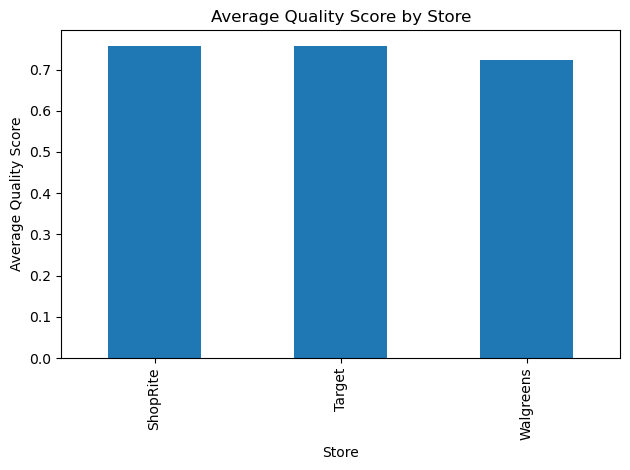

In [14]:
import matplotlib.pyplot as plt

# Build a DataFrame of overall scores for plotting
plot_df = pd.DataFrame({
    "food": [i.name for i in items],
    "store": [i.store for i in items],
    "score": [i.metric.overall_score() for i in items],
    "price": [i.price for i in items],
})

# Average score per store
store_avg = plot_df.groupby("store")["score"].mean().sort_values(ascending=False)

plt.figure()
store_avg.plot(kind="bar")
plt.title("Average Quality Score by Store")
plt.ylabel("Average Quality Score")
plt.xlabel("Store")
plt.tight_layout()
plt.show()


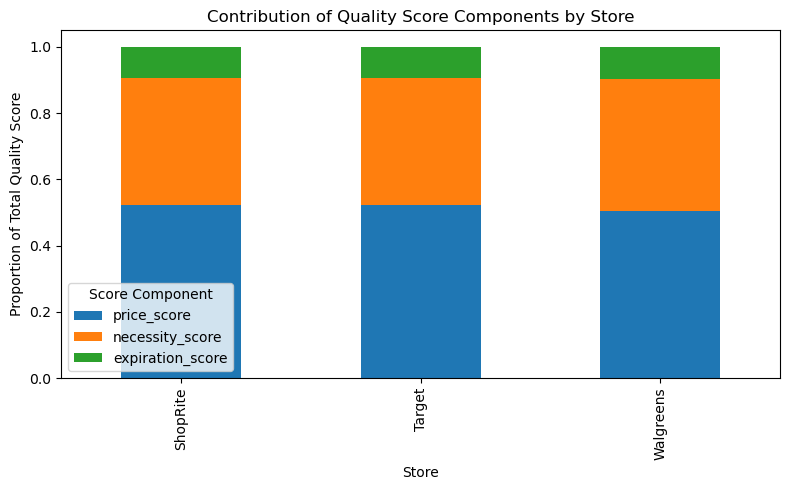

In [15]:
# Score Proportion Breakdown: shows how important each score is for quality. (Noah Ferro)
import matplotlib.pyplot as plt
# New dataframe
plot_df = pd.DataFrame({
    "food": [i.name for i in items],
    "store": [i.store for i in items],
    "price_score": [i.metric.price_score for i in items],
    "necessity_score": [i.metric.necessity_score for i in items],
    "expiration_score": [i.metric.expiration_score for i in items],
    "overall_score": [i.metric.overall_score() for i in items],
})
store_components = (
    plot_df
    .groupby("store")[["price_score", "necessity_score", "expiration_score"]]
    .mean()
)
store_props = store_components.div(
    store_components.sum(axis=1), axis=0
)
import matplotlib.pyplot as plt
store_props.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)
plt.title("Contribution of Quality Score Components by Store")
plt.ylabel("Proportion of Total Quality Score")
plt.xlabel("Store")
plt.legend(title="Score Component")
plt.tight_layout()
plt.show()

In [16]:
# Decision Criterion (Noah Ferro)
def print_final_recommendation(items):
    """
    Gives us a recommendation based on average quality scores for each store using all items.
    """
    import pandas as pd
    #new datafram using items
    df = pd.DataFrame({
        "store": [i.store for i in items],
        "score": [i.metric.overall_score() for i in items]
    })
    # Computes the average score per store
    store_avg = df.groupby("store")["score"].mean().sort_values(ascending=False)
    best_store = store_avg.index[0]
    best_score = store_avg.iloc[0]
    print("\n Based on the data, we recommend: ")
    print("-" * 35)
    for store, score in store_avg.items():
        print(f"{store}: average quality score = {score:.3f}")
    print("\nBest store:")
    print(f" {best_store} (highest average quality score: {best_score:.3f})")
    print("\nReasons why:")
    print(
        f"{best_store} consistently provides better value across price accessibility, "
        "item necessity, and expiration longevity, resulting in the highest overall "
        "quality score among the evaluated stores."
    )
print_final_recommendation(items)


 Based on the data, we recommend: 
-----------------------------------
ShopRite: average quality score = 0.757
Target: average quality score = 0.757
Walgreens: average quality score = 0.723

Best store:
 ShopRite (highest average quality score: 0.757)

Reasons why:
ShopRite consistently provides better value across price accessibility, item necessity, and expiration longevity, resulting in the highest overall quality score among the evaluated stores.


In [17]:
# Stock reliability score (hypothetical 4th variable) (Noah Ferro)
# The score will be between 0 and 1, 1 being always available, 0 being completely unavailable.
""" changes model to price_score + necessity_score + expiration_score + availability_score / 4 
This will place less weight on the previous variables. Stock reliability tells us how often items
are available at a certain store, making our model more realistic by adding a supply/demand factor."""
#Example, if shoprite had an availability score of 0.95 and walgreens of 0.80. Item: Milk
class QualityMetric:
    def __init__(self, price_score, necessity_score, expiration_score, availability_score=0.0):
        self.price_score = price_score
        self.necessity_score = necessity_score
        self.expiration_score = expiration_score
        self.availability_score = availability_score  # Properly assign the attribute
    def overall_score(self):
        return (
            self.price_score +
            self.necessity_score +
            self.expiration_score +
            self.availability_score
        ) / 4
# Import random to make availability for stores more realistic.
import random
random.seed(42)
# Simulate random availabilites for each store.
def simulate_availability(store):
    if store == "ShopRite":
        return round(random.uniform(0.90, 0.98), 2)
    elif store == "Walgreens":
        return round(random.uniform(0.75, 0.88), 2)
    else:
        return round(random.uniform(0.80, 0.90), 2)
for item in items:
    if not hasattr(item.metric, 'availability_score'):
        # Get the store name from the item
        store_name = item.store
        # Calculate availability score
        avail_score = simulate_availability(store_name)
        # Create a new metric with all the old values plus the availability score
        new_metric = QualityMetric(
            item.metric.price_score,
            item.metric.necessity_score,
            item.metric.expiration_score,
            avail_score
        )
        # Replacing old metric for availability
        item.metric = new_metric
# New dataframe including availability
plot_df = pd.DataFrame({
    "food": [i.name for i in items],
    "store": [i.store for i in items],
    "price_score": [i.metric.price_score for i in items],
    "necessity_score": [i.metric.necessity_score for i in items],
    "expiration_score": [i.metric.expiration_score for i in items],
    "availability_score": [i.metric.availability_score for i in items],
    "overall_score": [i.metric.overall_score() for i in items],
})

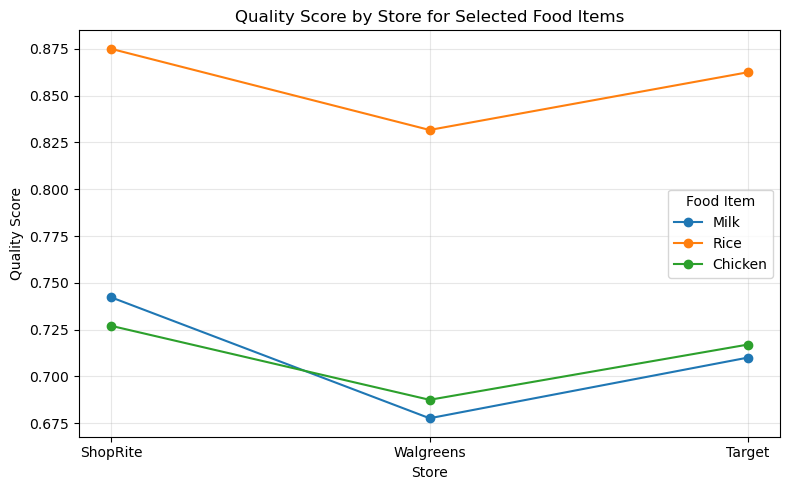

In [18]:
# Graph store of item vs quality for better understanding of quality score (Noah Ferro)
import matplotlib.pyplot as plt
plot_df = pd.DataFrame({
    "food": [i.name for i in items],
    "store": [i.store for i in items],
    "quality_score": [i.metric.overall_score() for i in items],
})
foods_to_plot = ["Milk", "Rice", "Chicken"] #Picked foods of highest necessity to simplify graph.
plot_df = plot_df[plot_df["food"].isin(foods_to_plot)]
plt.figure(figsize=(8, 5))
for food in foods_to_plot:
    food_df = plot_df[plot_df["food"] == food]
    plt.plot(
        food_df["store"],
        food_df["quality_score"],
        marker="o",
        label=food
    )
plt.title("Quality Score by Store for Selected Food Items")
plt.xlabel("Store")
plt.ylabel("Quality Score")
plt.legend(title="Food Item")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# User input for new data - potential app or website function 1. (Noah Ferro)
def calculate_quality_from_user_input(
    avg_price_lookup,
    max_expiration_days,
    availability_lookup=None
):
    """
   Asks user for details to return a quality score.
    """
    print("\nEnter your food, store, price, expiration and necessity below!")
    print("-" * 25)
    food = input("Food item name: ")
    store = input("Store name: ")
    price = float(input("Price ($): "))
    expiration_days = int(input("Expiration days: "))
    necessity = int(input("Necessity score (1–5): "))
    # Normalizing the components
    avg_price = avg_price_lookup.get(food, price)
    price_score = accessibility_score(price, avg_price)
    necessity_score = necessity / 5.0
    expiration_score = expiration_days / max_expiration_days
    #Taking in additional availability variable.
    if availability_lookup:
        availability_score = availability_lookup.get(store, 0.85)
    else:
        availability_score = None
    #Quality Score calculated
    if availability_score is not None:
        metric = QualityMetric(
            price_score,
            necessity_score,
            expiration_score,
            availability_score
        )
    else:
        metric = QualityMetric(
            price_score,
            necessity_score,
            expiration_score
        )
    print("\nQuality Scores")
    print("-" * 30)
    print(f"Price score:        {price_score:.3f}")
    print(f"Necessity score:    {necessity_score:.3f}")
    print(f"Expiration score:  {expiration_score:.3f}")
    if availability_score is not None:
        print(f"Availability score:{availability_score:.3f}")
    print("\nTherefore, your overall quality score is:")
    print(f" {metric.overall_score():.3f}")

In [20]:
# Application / Website function 2 - recommendations based on user input. (Noah Ferro)
def compare_stores_for_item(
    food,
    price_dict,
    expiration_days,
    necessity,
    stores,
    avg_price_lookup,
    max_expiration_days,
    availability_lookup=None
):
    """
   Based on the user input, this will give quality score AND recommendations for which store to use.
    """
    print(f"\nLets compare quality scores for: '{food}'")
    print("-" * 40)
    store_scores = {}
    for store in stores:
        #price will use user input, unless no input, then data set.
        price = price_dict.get(store, avg_price_lookup.get(food, 0))      
        price_score = accessibility_score(price, avg_price_lookup.get(food, price))
        necessity_score = necessity / 5.0
        expiration_score = expiration_days / max_expiration_days
        availability_score = availability_lookup.get(store, 0.85) if availability_lookup else None       
        if availability_score is not None:
            metric = QualityMetric(price_score, necessity_score, expiration_score, availability_score)
        else:
            metric = QualityMetric(price_score, necessity_score, expiration_score)
        store_scores[store] = metric.overall_score()
        print(f"{store}: {metric.overall_score():.3f}")  
    best_store = max(store_scores, key=store_scores.get)
    print("\nRecommended Store:")
    print(f" {best_store} (highest quality score: {store_scores[best_store]:.3f})")


In [22]:
# To make this app even more enticing, lets use sliders by installing ipywdigets (Noah Ferro)
def accessibility_score(price, avg_price):
    #This allows for Lower price to equal higher accessibility, realistic for grocery markets.
    if price <= avg_price:
        return 1.0
    else:
        return max(0.0, 1.0 - (price - avg_price) / avg_price)
class QualityMetric:
    def __init__(self, price_score, necessity_score, expiration_score, availability_score):
        self.price_score = price_score
        self.necessity_score = necessity_score
        self.expiration_score = expiration_score
        self.availability_score = availability_score   
    def overall_score(self):
        # Simple average of all scores
        return (self.price_score + self.necessity_score + 
                self.expiration_score + self.availability_score) / 4
stores = ["ShopRite", "Walgreens"]
foods = ["Milk", "Eggs", "Bread", "Rice", "Chicken"]
avg_price_lookup = {
    "Milk": 3.74, "Eggs": 4.44, "Bread": 2.99, "Rice": 6.24, "Chicken": 10.24
}
max_expiration_days = 365
availability_lookup = {"ShopRite": 0.95, "Walgreens": 0.80}
""" Use ipywidgets to make sliders in jupyter that could be interacted with. 
If we wanted a more app-like experience we could use streamlit separate from this notebook. 
The sliders would function the same but the UI would be very different. Good for future app and
website use to make this real. """
import ipywidgets as widgets
from IPython.display import display, clear_output
# Creates widgets
food_dropdown = widgets.Dropdown(options=foods, description='Food:')
store_dropdown = widgets.Dropdown(options=stores, description='Store:')
def get_avg_price(food):
    return avg_price_lookup.get(food, 5.0)
price_slider = widgets.FloatSlider(
    min=0.0, max=2*get_avg_price(food_dropdown.value), 
    value=get_avg_price(food_dropdown.value),
    step=0.01, description='Price ($):'
)

expiration_slider = widgets.IntSlider(
    min=1, max=max_expiration_days, value=7, step=1, description='Expiration Days:'
)

necessity_slider = widgets.IntSlider(
    min=1, max=5, value=3, step=1, description='Necessity (1-5):'
)

# This updates the slider with price change
def update_price_range(change):
    avg_price = get_avg_price(change['new'])
    price_slider.max = 2 * avg_price
    price_slider.value = avg_price

food_dropdown.observe(update_price_range, names='value')
output = widgets.Output()

# The calculate button 
calculate_button = widgets.Button(description="Calculate Quality Score")

# The Function to calculate and display results
def calculate_quality(b):
    with output:
        clear_output()       
        food = food_dropdown.value
        store = store_dropdown.value
        price = price_slider.value
        expiration_days = expiration_slider.value
        necessity = necessity_slider.value       
        avg_price = avg_price_lookup.get(food, 5.0)        
        price_score = accessibility_score(price, avg_price)
        necessity_score = necessity / 5.0
        expiration_score = expiration_days / max_expiration_days
        availability_score = availability_lookup.get(store, 0.85)       
        metric = QualityMetric(price_score, necessity_score, expiration_score, availability_score)       
        print("Quality Score Breakdown")
        print(f"Price Score: {price_score:.3f}")
        print(f"Necessity Score: {necessity_score:.3f}")
        print(f"Expiration Score: {expiration_score:.3f}")
        print(f"Availability Score: {availability_score:.3f}")
        print("\nOverall Quality Score")
        print(f"→ {metric.overall_score():.3f}")
calculate_button.on_click(calculate_quality)
display(food_dropdown, store_dropdown, price_slider, expiration_slider, necessity_slider, calculate_button, output)

Dropdown(description='Food:', options=('Milk', 'Eggs', 'Bread', 'Rice', 'Chicken'), value='Milk')

Dropdown(description='Store:', options=('ShopRite', 'Walgreens'), value='ShopRite')

FloatSlider(value=3.74, description='Price ($):', max=7.48, step=0.01)

IntSlider(value=7, description='Expiration Days:', max=365, min=1)

IntSlider(value=3, description='Necessity (1-5):', max=5, min=1)

Button(description='Calculate Quality Score', style=ButtonStyle())

Output()

In [11]:
%cd ..

/var/www/filebrowser/.projects/d30108ff-ec67-4733-bfac-af4c728939ff/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project


In [12]:
!ls


README.md  data  notebook  src	tests


In [13]:
!pytest


============================= test session starts ==============================
platform linux -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0
rootdir: /var/www/filebrowser/.projects/d30108ff-ec67-4733-bfac-af4c728939ff/AAI-CPE-EE-551-Matthew-Lyulko-and-Noah-Ferro-Final-Project
plugins: anyio-3.5.0
collected 2 items                                                              

tests/test_metrics.py ..                                                 [100%]

============================== 2 passed in 0.16s ===============================
